In [25]:
import numpy as np
import matplotlib.pyplot as plt
import mesa_reader as mr
from scipy import interpolate
import emcee

In [3]:
mearth = 5.97e27
msun = 1.9892e33
rearth = 6.371008e8
rsun = 6.9598e10
rfrac = rsun/rearth
mfrac = msun/mearth

In [4]:
def formatstring(myfloat):
    return '%.5f'%myfloat

In [5]:
npzfile3 = np.load('146b_data3.npz',allow_pickle=True)
masses = npzfile3['masses3']
radii = npzfile3['radii3']
fs = npzfile3['fs3']
ages = npzfile3['ages3']

In [6]:
initial_masses = np.linspace(5.3,6.3,11)
initial_fs = np.linspace(0.004,0.014,11)

In [7]:
final_masses = np.array([masses[i][-1] for i in range(len(masses))])
final_fs = np.array([fs[i][-1] for i in range(len(fs))])
final_radii = np.array([radii[i][-1] for i in range(len(radii))])
final_ages = np.array([ages[i][-1] for i in range(len(ages))])

In [8]:
grid_fs, grid_ms = np.meshgrid(initial_fs, initial_masses)
grid_fs, grid_ms = grid_fs.flatten(), grid_ms.flatten()
grid_points = np.column_stack((grid_ms, grid_fs))
print(grid_points.shape)
print(final_radii.shape)

(121, 2)
(121,)


In [9]:
#age interpolation
radii_5gyr = []
masses_5gyr = []
newage = 5.0e9

for i in range(0,len(ages)):
    if ages[i][-1] < newage:
        radii_5gyr.append(np.nan)
        masses_5gyr.append(np.nan)
        
    else:
        radii_age_interp = interpolate.interp1d(ages[i],radii[i],kind='linear')
        radii_5gyr.append(radii_age_interp(newage))
        
        masses_age_interp = interpolate.interp1d(ages[i],masses[i],kind='linear')
        masses_5gyr.append(masses_age_interp(newage))

In [19]:
#final mass, radius interpolation from intial values

radius_interp = interpolate.LinearNDInterpolator(grid_points,final_radii)

mass_interp = interpolate.LinearNDInterpolator(grid_points,final_masses)

In [41]:
mass_interp(5.75, 0.0041)
radius_interp(5.75, 0.0041)

array(1.8084415)

In [47]:
#test? likelihood function
def log_likelihood(x, mu_m, sigma_m, mu_r, sigma_r):
    #2 dimensions, mass and radius
    #K2-146b: measured mass m = 5.77 +/- 0.18 M_E
    #measured radius 2.05 +/- 0.06 R_E
    #x[0] = mass
    #x[1] = f
    
    #Gaussian likelihood
    #up to constant?
    lval = - 0.5 * ( (( (mass_interp(x[0],x[1]) - mu_m) / sigma_m ) ** 2) + (( (radius_interp(x[0],x[1]) - mu_r) / sigma_r ) ** 2) )
    
    if np.isnan(lval):
        lval = -np.inf
    
    return lval

In [57]:
'''print(log_likelihood(5.78, 2.05))
print(log_likelihood(6.92, 2.55))
print(log_likelihood(3.4,1.7))'''

'print(log_likelihood(5.78, 2.05))\nprint(log_likelihood(6.92, 2.55))\nprint(log_likelihood(3.4,1.7))'

In [77]:
ndim = 2
nwalkers = 16

p0 = np.random.rand(nwalkers, ndim)
p0[:,0] = p0[:,0] + 5.3
p0[:,1] = p0[:,1] * 0.01 + 0.004 

In [66]:
#help(np.random.rand)

In [78]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[5.77, 0.18, 2.05, 0.06])

In [79]:
state = sampler.run_mcmc(p0,250)
sampler.reset()

In [80]:
var = sampler.run_mcmc(state,10000)

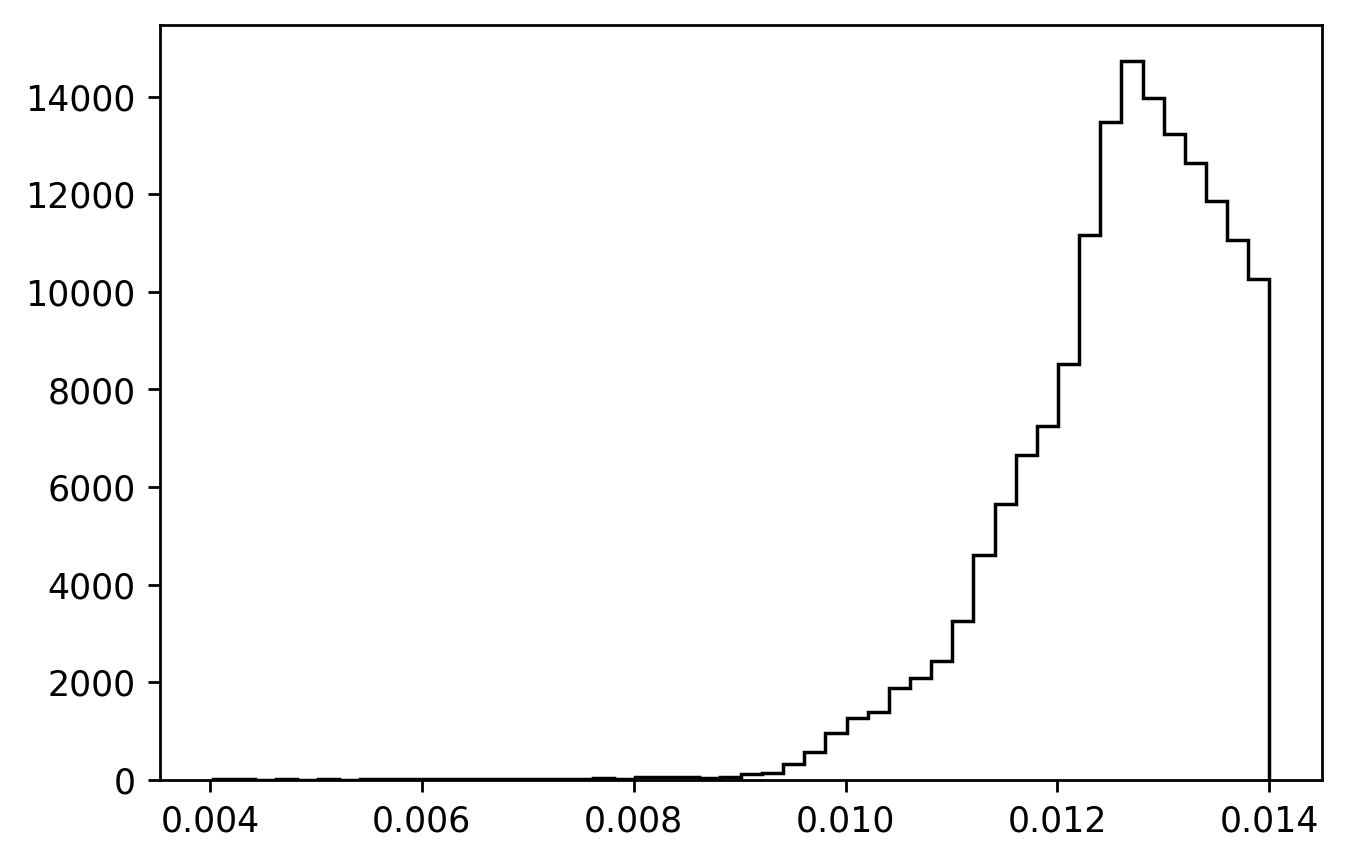

In [85]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:,1],50,color='k',histtype='step')
plt.gcf().set_dpi(250)

In [82]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.695
